In [5]:
import ee
ee.Initialize()
import sys
sys.path.append('../Configs/')
from global_func import GEELoadImage, masks2clouds
import SecondIterationModel as constants
import time
from math import ceil,floor
from tqdm.notebook import tqdm
import folium

0
0
1
1
2
2
3
3
32
4
33
5
34
6
35
7
64
8
65
9
66
10
67
11
96
12
97
13
98
14
99
15


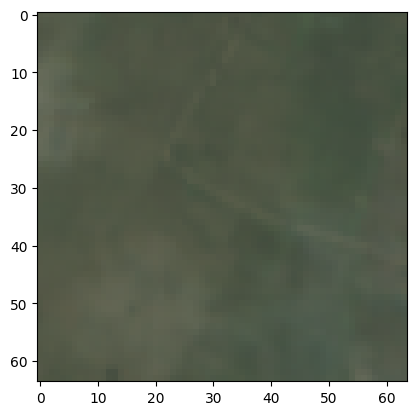

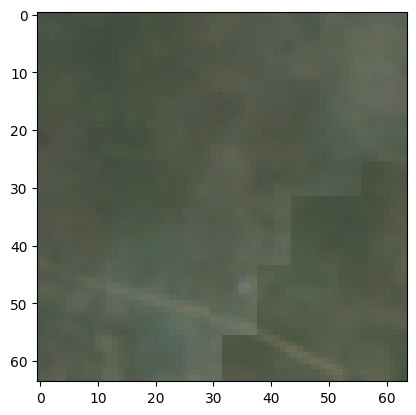

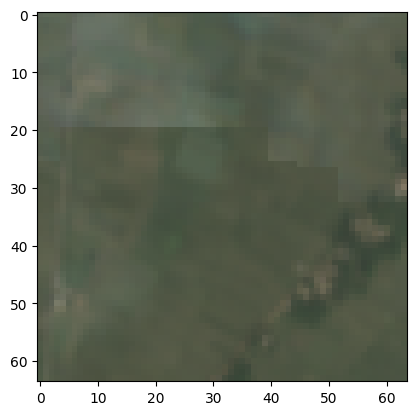

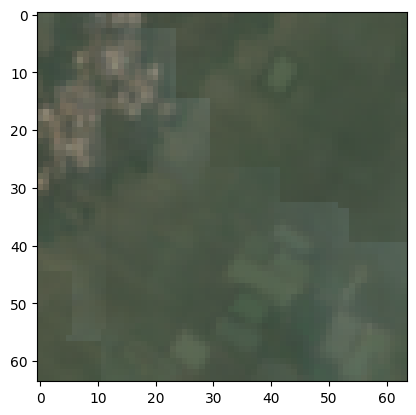

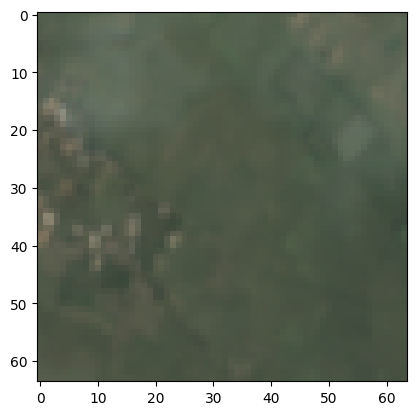

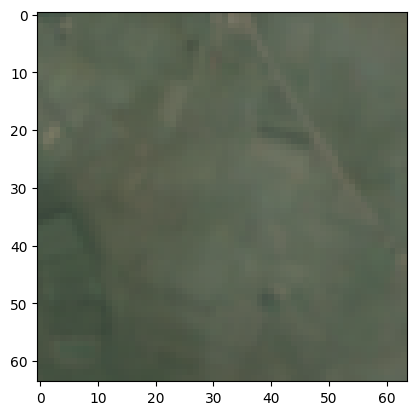

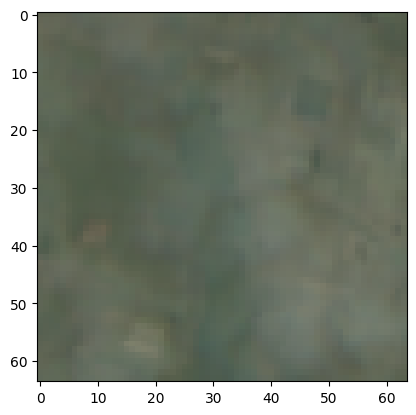

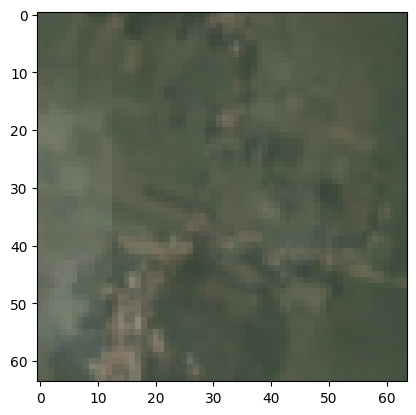

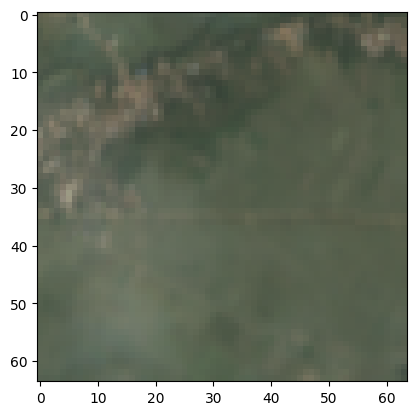

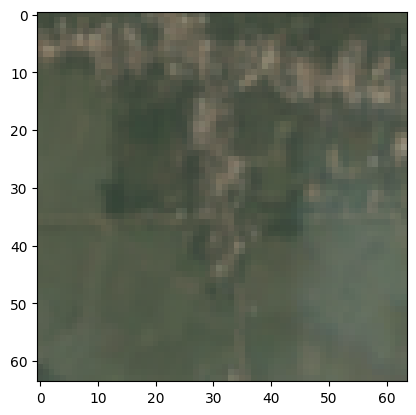

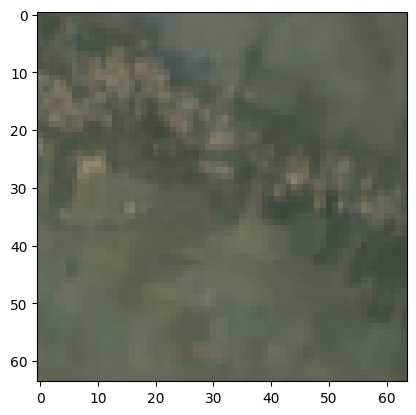

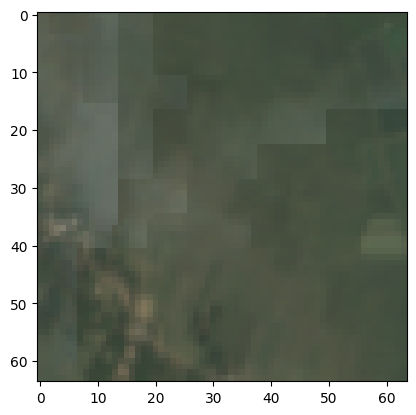

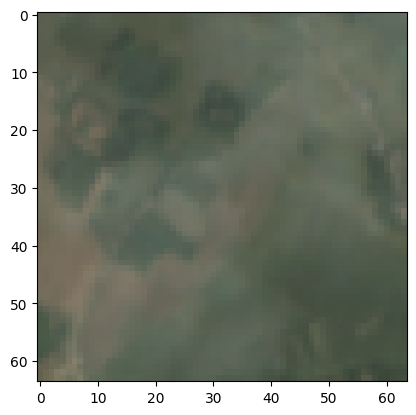

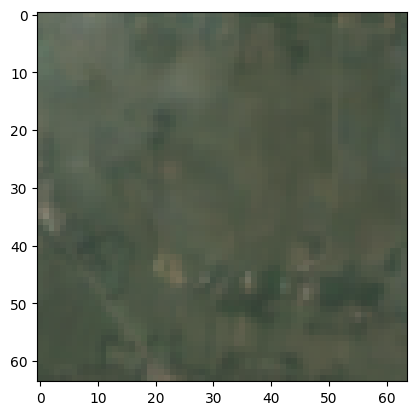

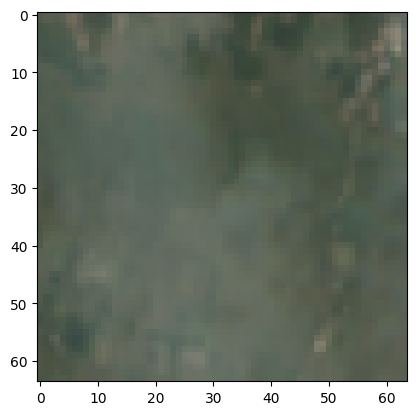

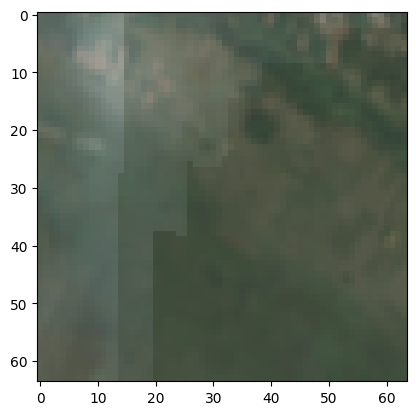

In [46]:
start_time=time.time()
data=[]
location = ee.FeatureCollection(constants.GEE_COUNTRY_DATASET).filter(ee.Filter.eq('country_na','Bangladesh'))
tgeo=location.geometry().coveringGrid("EPSG:3857",22400)
tgeoList=[]
for x in range(ceil(tgeo.size().getInfo()/5000)):
    tgeoBatch=tgeo.toList(5000,5000*x).getInfo()
    tgeoList.extend(tgeoBatch)

tile_geometries = tgeoList[constants.DEPLOY_START_FROM:]
subtile_geometries = ee.Geometry(tile_geometries[200]['geometry']).coveringGrid("EPSG:3857",700).getInfo()['features']
batches=ee.Geometry(tile_geometries[200]['geometry']).coveringGrid('EPSG:3857',2800).getInfo()['features']
lowres_collection=ee.ImageCollection(constants.GEE_SATELLITE).filterDate(constants.GEE_START_DATE,constants.GEE_END_DATE)

for filters,bounds in zip(constants.GEE_FILTERS,constants.GEE_FILTERS_BOUNDS):
    lowres_collection=lowres_collection.filter(ee.Filter.lte(filters,bounds))
lowres_collection=lowres_collection.map(masks2clouds)
img_data=[None]*1024
idx=[None]*1024
for bindex,batch in enumerate(batches[:1]):
    startbx=bindex%8
    startby=floor(bindex/8)
    batch_subtiles=[]
    for y in range(4):
        batch_subtiles.extend(list(range(((128*startby)+(32*y))+(4*startbx),((128*startby)+(32*y))+(4*(startbx+1)))))

    try: 
        lowRes_collection=lowres_collection.filterBounds(ee.Geometry(batch['geometry']))
        image=lowRes_collection.mean()
        buff=[constants.GEE_MAX_PIXEL_VALUE,constants.GEE_IMAGE_FORMAT,constants.GEE_IMAGE_SHAPE*4]
        data=GEELoadImage(image,batch['geometry'],buff,rgb_only=True)
    except Exception as e:
        print(e)
        data=None

    #Iterate through the subtiles and load the image into it's respective class variable
    for index,ind in enumerate(batch_subtiles):
        print(ind)
        print(index)
        cur=0*1024+ind
        if data is None:
            img_data[ind]=data
        else:
            startx=(index%4)*64
            starty=(3-floor(index/4))*64
            img_data[ind]=data[starty:starty+64,startx:startx+64,:]
            plt.figure()
            plt.imshow(img_data[ind])
        idx[ind]=cur

1024
{'type': 'Feature', 'geometry': {'geodesic': False, 'crs': {'type': 'name', 'properties': {'name': 'EPSG:3857'}}, 'type': 'Polygon', 'coordinates': [[[9902900, 2712500], [9903600, 2712500], [9903600, 2713200], [9902900, 2713200], [9902900, 2712500]]]}, 'id': '14147,3875', 'properties': {}}


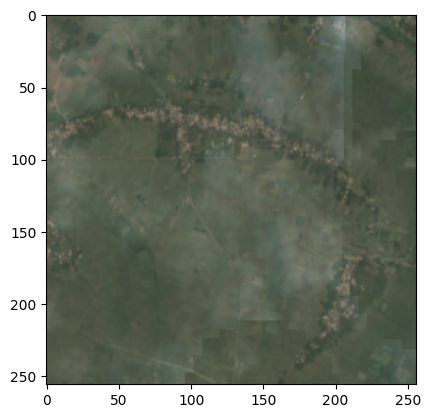

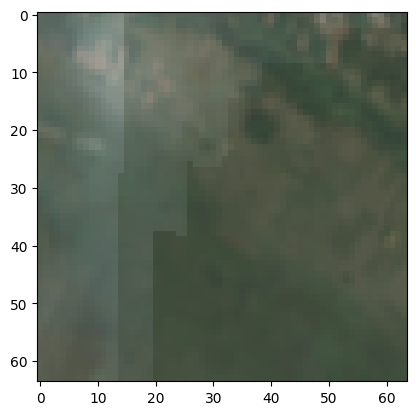

In [48]:
import matplotlib.pyplot as plt
print(len(img_data))
plt.imshow(data)
plt.figure()
plt.imshow(img_data[batch_subtiles[15]])
print(subtile_geometries[batch_subtiles[15]])

In [40]:
m = folium.Map()
style= {'fillColor': '#228B22', 'color': '#228B22'}
test=folium.GeoJson(ee.Geometry(tile_geometries[200]['geometry']).transform("EPSG:4326",1).getInfo(),name='tile')
test.add_to(m)
test=folium.GeoJson(ee.Geometry(subtile_geometries[batch_subtiles[0]]['geometry']).transform("EPSG:4326",1).getInfo(),name='tile',style_function=lambda x:style)
test.add_to(m)
test=folium.GeoJson(ee.Geometry(batches[0]['geometry']).transform("EPSG:4326",1).getInfo(),name='tile')
test.add_to(m)
m

In [2]:
start_time=time.time()
data=[]
location = ee.FeatureCollection(constants.GEE_COUNTRY_DATASET).filter(ee.Filter.eq('country_na','Bangladesh'))
tgeo=location.geometry().coveringGrid("EPSG:3857",22400)
tgeoList=[]
for x in range(ceil(tgeo.size().getInfo()/5000)):
    tgeoBatch=tgeo.toList(5000,5000*x).getInfo()
    tgeoList.extend(tgeoBatch)

tile_geometries = tgeoList[constants.DEPLOY_START_FROM:]
subtile_geometries = ee.Geometry(tile_geometries[200]['geometry']).coveringGrid("EPSG:3857",700).getInfo()['features']
batches=ee.Geometry(tile_geometries[200]['geometry']).coveringGrid('EPSG:3857',2800).getInfo()['features']
lowres_collection=ee.ImageCollection(constants.GEE_SATELLITE).filterDate(constants.GEE_START_DATE,constants.GEE_END_DATE)
for filters,bounds in zip(constants.GEE_FILTERS,constants.GEE_FILTERS_BOUNDS):
    lowres_collection=lowres_collection.filter(ee.Filter.lte(filters,bounds))
lowres_collection=lowres_collection.map(masks2clouds)
lowRes_collection=lowres_collection.filterBounds(ee.Geometry(tile_geometries[200]['geometry']))
image=lowRes_collection.mean()
buff=[constants.GEE_MAX_PIXEL_VALUE,constants.GEE_IMAGE_FORMAT,constants.GEE_IMAGE_SHAPE*32]
data.append(GEELoadImage(image,tile_geometries[200]['geometry'],buff,rgb_only=True))
"""
for subtile in tqdm(subtile_geometries):
    lowRes_collection=lowres_collection.filterBounds(ee.Geometry(subtile['geometry']))
    image=lowRes_collection.mean()
    buff=[constants.GEE_MAX_PIXEL_VALUE,constants.GEE_IMAGE_FORMAT,constants.GEE_IMAGE_SHAPE]
    data.append(GEELoadImage(image,subtile['geometry'],buff,rgb_only=True))
"""
print(time.time()-start_time)

22.925163745880127


In [10]:
m = folium.Map()
style= {'fillColor': '#228B22', 'color': '#228B22'}
test=folium.GeoJson(ee.Geometry(tile_geometries[200]['geometry']).transform("EPSG:4326",1).getInfo(),name='tile',style_function=lambda x:style)
test.add_to(m)
test=folium.GeoJson(ee.Geometry(batches[16]['geometry']).transform("EPSG:4326",1).getInfo(),name='tile')
test.add_to(m)

m

In [28]:
print(type(tile_geometries[200]['geometry']))

<class 'dict'>


In [23]:
print(subtile_geometries[-34])

{'type': 'Feature', 'geometry': {'geodesic': False, 'crs': {'type': 'name', 'properties': {'name': 'EPSG:3857'}}, 'type': 'Polygon', 'coordinates': [[[9921800, 2731400], [9922500, 2731400], [9922500, 2732100], [9921800, 2732100], [9921800, 2731400]]]}, 'id': '14174,3902', 'properties': {}}


(2048, 2048, 3)


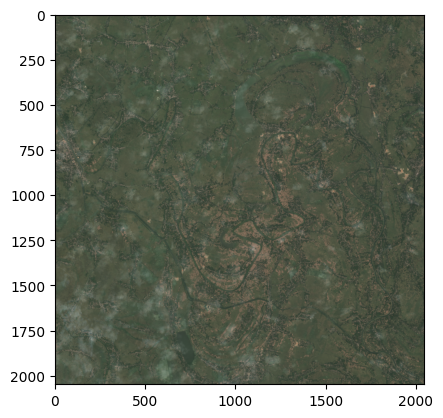

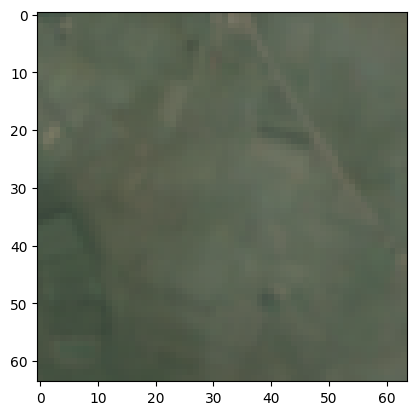

In [25]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(data[0])
plt.figure()
plt.imshow(data[0][-128:-64,64:128,:])
print(data[0].shape)